In [1]:
#Add the folder to the path:
import sys
sys.path.append('../')
from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve, sesolve, mesolve)
from qutip.expect import expect
import numpy as np
from util.samplers_util import thermal_rejection
import matplotlib.pyplot as plt
from util.basic_TFIM_funcs import get_s_lists
from joblib import Parallel, delayed


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:

import os

#Move the directory back to Duke_Data
#Check if the current directory is Duke_Data
if os.getcwd().split('/')[-1] != 'DUKE_ANALOG_ZNE_DATA':
    #os.chdir('Duke_Data')
    os.chdir('../')
    #print(os.getcwd().split('/')[-1])
    #pass
else:
    pass
print(os.getcwd())
from util.functions_util import cetina_thermal_exp, cetina_envelope_exp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import numpy as np
import h5py
from util.fitting_functions_ZNE import linear_ZNE, third_no_first_ZNE, quadratic_only_ZNE, exp_ZNE, log_fit_exp_ZNE, gaussian_ZNE


/Users/thomassteckmann/Duke_Analog_ZNE_data


In [3]:
# import all the useful lib in python
from matplotlib import artist as art
%matplotlib inline
import scipy as sp
# import pandas as pd
import pathlib
import os
import datetime as dt
import glob
from IPython.display import clear_output
from numpy.fft import fft, ifft

from util.h5analysis import *
from util.qsim_functions import*


In [4]:
import numpy as np
from scipy.signal import find_peaks, savgol_filter

def find_peaks_in_data(data, height):
    peaks, _ = find_peaks(data, height=height)
    return peaks


def find_peaks_smooth(data, height, window_length, polyorder):
    # Apply Savitzky-Golay filter to smooth data
    smoothed_data = savgol_filter(data, window_length, polyorder)
    
    # Find peaks in smoothed data
    peaks, _ = find_peaks(smoothed_data, height=height)

    return peaks


In [8]:
#Pairs:
# wait_times = [0.000000, 0.119841, 0.359523, 0.719045, 0.958727, 1.198409, 1.797613, 2.396818, 3.595226]
# data_names = ['000558346','000558347','000558348','000558349','000558350','000558352']
# data_folder = 'Jij_Extrapolation'

## Looking at the detuning scanning for a single pair
data_folder = 'Detune_scanning'
data_names = [955, 956, 970,957, 962, 963, 969,964, 965]
info =       [-45, -50, -51,-55, -60, -65, -68,-70, -75]
prefix = '000574'
shots=150
pair = (4,5)


#Narrow detune scanning for a single pair 1,2
# data_folder = 'detune_Jij'
# data_names = ['053', '051', '055', '052', '054']
# info =       [-49, -47, -45, -43, -41]
# prefix = '000575'
# pair = (2,3)
# shots = 150
# J = 0.51*np.pi




# data_folder = 'JIJ_PAIRS_ROUND_2'
# data_names = [161,181,182,183,184,185,186,187,188,189,190,191, 192]
# info = [(5,6),(6,7),(7,8),(8,9),(9,10),(10,11),(11,12),(12,13),(13,14),(14,15),(15,16),(16,17),(17,18)]
# #data_names = [161]
# #info = [(5,6)]
# prefix = '000563'
# shots = 150
# #pair = (5,6)
# J = 1.2*np.pi


#Checking 15 qubit SPAM leakage
# data_folder = 'Jij_SPAM_15'
# data_names = [230]#,161,181,182,183,184,185,186,187,188,189,190,191, 192]
# info = [(2,3)]#,(5,6),(6,7),(7,8),(8,9),(9,10),(10,11),(11,12),(12,13),(13,14),(14,15),(15,16),(16,17),(17,18)]
# prefix = '000575'
# shots = 600
# pair = (2,3)
# J = 1.2*np.pi

# data_folder = 'JIJ_PAIRS_ROUND_2'
# data_names = [346]#,161,181,182,183,184,185,186,187,188,189,190,191, 192]
# info = [(2,3)]#,(5,6),(6,7),(7,8),(8,9),(9,10),(10,11),(11,12),(12,13),(13,14),(14,15),(15,16),(16,17),(17,18)]
# prefix = '000563'
# shots = 600
# pair = (2,3)
# J = 1.2*np.pi

# data_folder = 'detune'
# data_names = ['053', '051', '055']
# info  = [(2,3), (2,3), (2,3)]
# prefix = '000574'
# shots = 150




# data_folder = 'DD_pulses'
# data_names = [844, 864, 872]
# info =       [0, 2, 4]
# prefix = '000572'
# pair = (4,5)
# shots = 200


data_names = [str(name) for name in data_names]
full_data_folder_path = './data/' + data_folder + '/'
for name_index in range(len(data_names)):
    name = data_names[name_index]
    if prefix in name:
        pass
    else:
        name = prefix + name
        data_names[name_index] = name
        

In [9]:
print()
COUNTS_THRESHOLD = 1

print(os.getcwd())



/Users/thomassteckmann/Duke_Analog_ZNE_data


In [10]:
results = np.zeros((len(data_names), 30))
leakage_matrix = np.zeros((30, len(data_names)))
flopping_matrix = np.zeros((30, len(data_names)))
flopping_std_matrix = np.zeros((30, len(data_names)))
flopping_matrix_ps = np.zeros((30, len(data_names)))
peaks_count = 6

peak_amplitudes = np.zeros((peaks_count, len(data_names)))
peak_leakages = np.zeros((peaks_count, len(data_names)))
peak_index = np.zeros((peaks_count, len(data_names)))
times = None

for file_id_index in range(len(data_names)):
    file_id = data_names[file_id_index]
    #pair = names[0]
    file = h5py.File(full_data_folder_path + file_id + '-RFSoCSequence.h5', 'r')
    archive = file['archive']
    dataset = file['datasets']
    if  isinstance(info[0],tuple):
        pair = info[file_id_index]
    x_vals = dataset['data.rfsoc_pulse_sequence.x_values']
    times = np.array(x_vals)
    #print(times)
    raw_counts = dataset['data.rfsoc_pulse_sequence.raw_counts']
    counts = np.asarray(raw_counts)
    #print(counts.shape)
    print(counts[:,0,10])
    measurements = np.zeros((2, shots, 30))
    for pair_index in range(len(pair)):
        qubit = pair[pair_index]
        measurements[pair_index,:,:] = 1 < counts[qubit,:,:]
        #print(measurements)
    #Convert the measurements to bitstrings. Convert to string, then append the like indices
    counts_bitstrings = np.zeros((shots, 30), dtype='<U5')
    expectations = np.zeros((shots, 30))
    ps_expectations = np.zeros((30,),dtype=list)
    #Set each element in ps_expectations to []
    for i in range(30):
        ps_expectations[i] = []
        
    for j in range(30):
        for i in range(shots):
            expectation = ((measurements[0,i,j]*2-1) - (measurements[1,i,j]*2-1))/2
            bitstring = str(int(measurements[0,i,j])) + str(int(measurements[1,i,j]))
            #print(bitstring)
            counts_bitstrings[i,j] = bitstring
            expectations[i,j] = expectation
            if bitstring == '00' or bitstring == '11':
                pass
            else:
                ps_expectations[j].append(expectation)
    ps_expecations_avg = np.array([np.mean(ps_expectations[i]) for i in range(30)])
    flopping_matrix_ps[:,file_id_index] = ps_expecations_avg
    #Post select and split bitsrings back into single qubits:
    #average expectations across the 150 axis:
    expectations_avg = np.mean(expectations, axis=0)
    #Convert counts_bitstrings to a dictionary of counts
    print(counts_bitstrings)
    counts_array  = np.zeros((30,), dtype=dict)
    for i in range(30):
        counts_array[i] = {}
        for j in range(shots):
            if counts_bitstrings[j,i] in counts_array[i]:
                counts_array[i][counts_bitstrings[j,i]] += 1
            else:
                counts_array[i][counts_bitstrings[j,i]] = 1
    
    leakage = np.zeros((30,))
    for i in range(30):
        if '00' in counts_array[i]:
            leakage[i] += counts_array[i]['00']/shots
        if '11' in counts_array[i]:
            leakage[i] += counts_array[i]['11']/shots
    leakage_conv = np.zeros((30,))
    for i in range(30):
        leakage_conv[i] = np.mean(leakage[i:i+3])
    leakage_matrix[:,file_id_index] = leakage#leakage_conv
    flopping_matrix[:,file_id_index] = expectations_avg
    flopping_std = np.std(expectations, axis=0)
    flopping_std_matrix[:,file_id_index] = flopping_std
    squared_flopping = np.square(expectations_avg)
    #print()
    ave_squared_flopping = np.mean(squared_flopping)
    peaks = find_peaks_smooth(squared_flopping, ave_squared_flopping/2, 5, 2)
    
    print(peaks)
    print(times[peaks])
    if len(peaks) == 7:
        peaks = peaks[:-1]
    if len(peaks) != 6:
        #Padd peaks to length 6:
        peaks = np.pad(peaks, (0, 6-len(peaks)), 'constant', constant_values=(10))
    peak_index[:,file_id_index] = peaks
    peak_amplitudes[:,file_id_index] = expectations_avg[peaks]
    peak_leakages[:,file_id_index] = leakage[peaks]


#Dived each elemnt of expecation by the associated element 1-leakage:
rescale_expectations = np.zeros((30, len(data_names)))
for i in range(30):
    rescale_expectations[i,:] = flopping_matrix[i,:]/(1-leakage_matrix[i,:])

[ 0.  0.  0.  0. 11.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[['10' '10' '01' ... '10' '01' '00']
 ['10' '10' '01' ... '10' '11' '10']
 ['10' '10' '11' ... '11' '11' '10']
 ...
 ['10' '11' '10' ... '00' '01' '01']
 ['10' '10' '01' ... '00' '01' '00']
 ['10' '10' '01' ... '11' '01' '01']]
[ 4  6  9 11 15 19 21]
[1.61535   2.423025  3.6345375 4.4422125 6.0575625 7.6729125 8.4805875]
[ 0.  0.  0.  0. 17.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[['10' '01' '01' ... '11' '10' '10']
 ['10' '10' '01' ... '01' '10' '10']
 ['10' '10' '01' ... '10' '10' '10']
 ...
 ['10' '10' '11' ... '10' '01' '10']
 ['10' '10' '10' ... '10' '10' '01']
 ['10' '00' '01' ... '10' '01' '10']]
[ 3  6  9 12 17 23]
[1.2115125 2.423025  3.6345375 4.84605   6.8652375 9.2882625]
[ 0.  0.  0.  0. 20.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[['10' '10' '01' ... '10' '01' '10']
 ['10' '10' '01' ... '10' '00' '10']
 ['10' '01' '01' ... '10' '10' '01']
 ...
 ['10' '10' '01' ... '10' '01' '10']
 ['10' '10' '01' ... '10' '0

In [11]:
# mask = np.zeros(peaks_count, dtype=bool)
# for i in range(peaks_count):
#     mask[i] = np.all(peak_leakages[i,:] < 1)



# plt.plot(1-peak_leakages[mask], color='r')
# plt.plot(np.abs(peak_amplitudes[mask]), color='k')

In [12]:
# colors = ['r', 'g', 'b', 'c', 'm', 'y']

# for i in range(len(data_names)):
#     plt.plot(times,1-leakage_matrix[:,i], color='b', label='leakage')
#     plt.plot(times,flopping_matrix[:,i], color=colors[i], label='Qubit pair' + str(info[i]))

# #Fit the leakage to a line:

# #plt.plot(1-leakage_matrix, color='r')

# #plt.plot(flopping_matrix, color='k')

In [13]:
#for i in range(len(data_names)):
#    plt.plot(leakage_matrix[:,i], color=colors[i])


In [14]:
#Fit each data set to exp(-gamma*t)*cos(omega*t)
#Create a new data set flopping_matrix_fit
flopping_matrix_fit = np.zeros(flopping_matrix.shape)
flopping_matrix_fit_dense = np.zeros((1000, len(data_names)))
dense_times = np.linspace(0, max(times), 1000)
 
flopping_std_matrix_fit = np.zeros(flopping_matrix.shape)
def exp_func (t, gamma, omega, A,B):
    return A*np.exp(-gamma*t)*np.cos(omega*t) + B
def leakage_exp(t, gamma, A):
    return A*np.exp(-gamma*t)

print(flopping_matrix.shape)
Omega = np.zeros((len(data_names),))
gammas = np.zeros((len(data_names),))
leakage_gamma = np.zeros((len(data_names),))
leakage_alpha = np.zeros((len(data_names),))
#print(times)
prefactors = np.zeros((len(data_names),))
for i in range(len(data_names)):
    popt, pcov = curve_fit(exp_func, times, flopping_matrix[:,i], p0=[0.04, 2, 0.8,0])
    popt2,pcov2 = curve_fit(leakage_exp, times, 1-leakage_matrix[:,i], p0=[0.04, 0.8])
    #popt, pcov = curve_fit(exp_func, times, flopping_matrix[:,i], p0=[0.04, 2, 1,0])
    #print(exp_func(times, *popt))
    Omega[i] = popt[1]
    gammas[i] = popt[0]
    prefactors[i] = popt[2]
    leakage_gamma[i] = popt2[0]
    leakage_alpha[i] = popt2[1]
    flopping_matrix_fit[:,i] = exp_func(times, *popt)
    flopping_matrix_fit_dense[:,i] = exp_func(dense_times, *popt)
    print(popt)
    #flopping_std_matrix_fit[:,i] = np.sqrt(np.diag(pcov))
print(Omega)
print(gammas)

(30, 9)
[0.09946636 3.03697008 0.98109688 0.03533753]
[0.09125909 2.76981011 1.03596367 0.03375245]
[0.08806922 2.77670371 0.95978771 0.03049058]
[0.08835135 2.49289571 1.01010759 0.0551878 ]
[0.12993967 2.34874561 0.9390542  0.02281847]
[0.07638812 2.1428719  1.01708481 0.06979901]
[0.18914572 2.12995866 0.87724121 0.02983274]
[0.06842096 1.9796673  0.97922624 0.09496263]
[0.06258144 1.85124714 0.99053237 0.06303591]
[3.03697008 2.76981011 2.77670371 2.49289571 2.34874561 2.1428719
 2.12995866 1.9796673  1.85124714]
[0.09946636 0.09125909 0.08806922 0.08835135 0.12993967 0.07638812
 0.18914572 0.06842096 0.06258144]


-45, -50, -51, -55, -60, -65, -68, -70, -75, 
0.0327518422874577, 0.032947777294154997, 0.03171718184182731, 0.03544125593352658, 0.055323008598400045, 0.035647543879809854, 0.08880252993660208, 0.034561846261989985, 0.03380501779831988, 


Text(0.5, 1.0, 'Scanning Detuning')

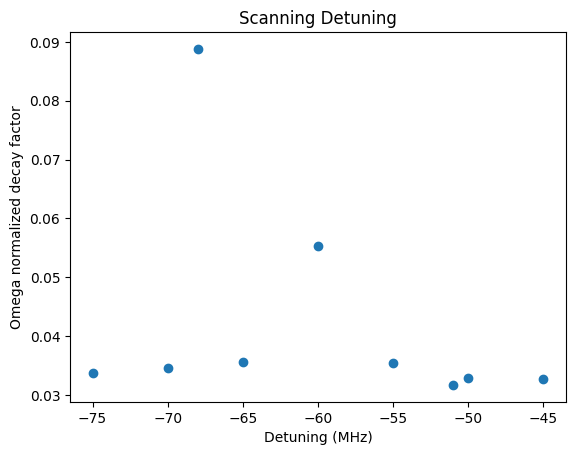

In [15]:
#plt.scatter(info, Omega)
plt.scatter(info, [gammas[i]/Omega[i] for i in range(len(data_names))])
string_obj = ''
string_obj2 = ''
for i in range(len(data_names)):
    string_obj += str(info[i]) + ', '
    string_obj2 += str(gammas[i]/Omega[i]) + ', '
print(string_obj)
print(string_obj2)
#print([str(info[i]) + ', ' for i in range(len(data_names))])
#print([str(gammas[i]/Omega[i]) + ', ' for i in range(len(data_names))])
#print(gammas/Omega)
plt.xlabel('Detuning (MHz)')
plt.ylabel('Omega normalized decay factor')
plt.title('Scanning Detuning')

(-52.0, -40.0)

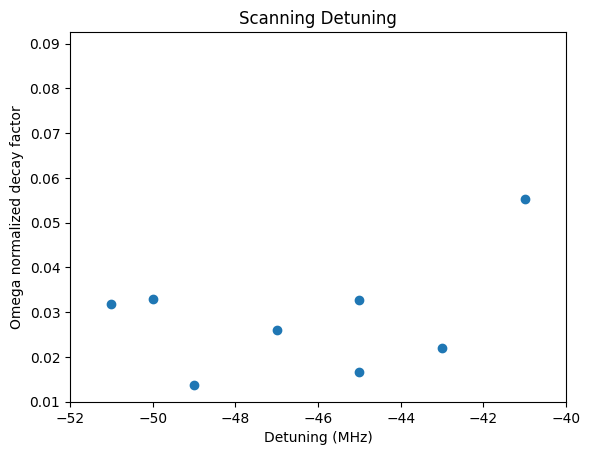

In [29]:
data_y = [0.0327518422874577, 0.032947777294154997, 0.03171718184182731, 0.03544125593352658, 0.055323008598400045, 0.035647543879809854, 0.08880252993660208, 0.034561846261989985, 0.03380501779831988, 0.013752354601738414, 0.02610359664272958, 0.016549799138881535, 0.022015466281115538, 0.055297128602205536]
data_x = [-45, -50, -51, -55, -60, -65, -68, -70, -75, -49, -47, -45, -43, -41]
plt.scatter(data_x, data_y)
plt.xlabel('Detuning (MHz)')
plt.ylabel('Omega normalized decay factor')
plt.title('Scanning Detuning')
plt.xlim(-52, -40)

0.09946636495763626
0.9810968818304663


Text(0.5, 1.0, 'Fitting the Leakage subspace, Exponential Fit')

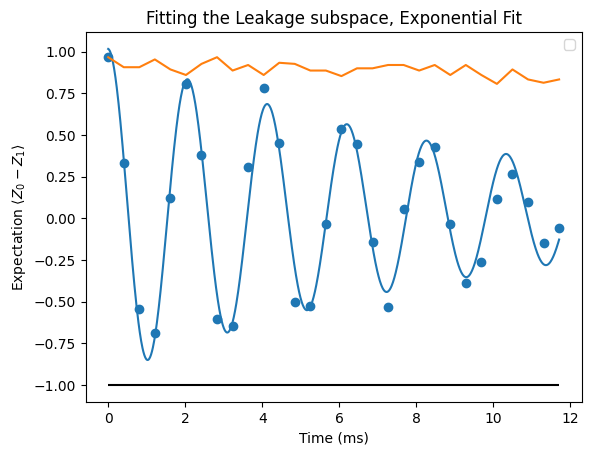

In [16]:
index = 0
plt.scatter(times, flopping_matrix[:,index])
plt.plot(dense_times, flopping_matrix_fit_dense[:,index])
plt.plot(times, 1-leakage_matrix[:,index])
print(gammas[index])
print(prefactors[index])
#plt.plot(times, exp_func(times, gammas[index], Omega[index], prefactors[index], 0))
plt.legend()
plt.ylabel(r'Expectation $\langle Z_0 - Z_1 \rangle$')
plt.xlabel('Time (ms)')
plt.hlines(-1, 0, max(times), colors='k')
plt.title('Fitting the Leakage subspace, Exponential Fit')
#print(info[index])
#Get the peak indices: 


Text(0.5, 1.0, 'Leakage Subspace vs. Exponential Fit')

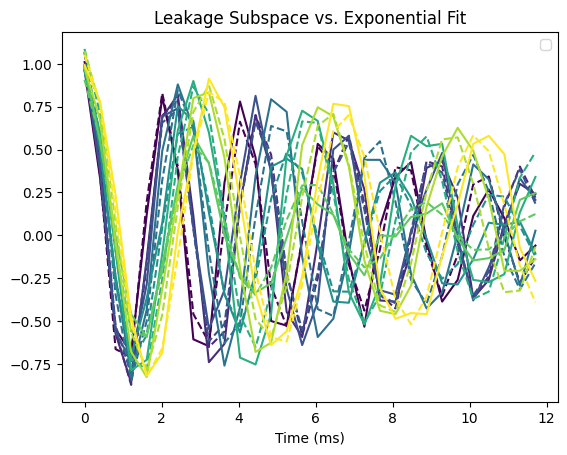

In [17]:
index = 0
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(data_names))]
for index in range(len(data_names)):
    plt.plot(times, flopping_matrix[:,index], color=colors[index])#, label='Qubit Pair' + str(info[index]))
    plt.plot(times, flopping_matrix_fit[:,index], color=colors[index], linestyle='--')
#plt.plot(times, leakage_matrix[:,index], label='Leakage')
#plt.plot(times, 1-np.exp(-gammas[index]*times), label='Exponential Decay')
plt.xlabel('Time (ms)')
plt.legend()
#plt.hlines(-1, 0, max(times), colors='k')
plt.title('Leakage Subspace vs. Exponential Fit')

Text(0.5, 1.0, 'Leakage Subspace vs. Exponential Fit')

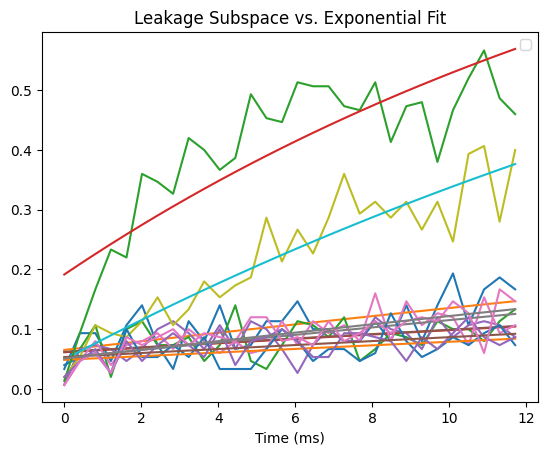

In [18]:
index = 0
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(data_names))]
for index in range(len(data_names)):
    #plt.plot(times, flopping_matrix[:,index], color=colors[index], label='Qubit Pair' + str(info[index]))
    #plt.plot(times, flopping_matrix_fit[:,index], color=colors[index], linestyle='--')
    plt.plot(times, leakage_matrix[:,index])
    plt.plot(times, 1-leakage_alpha[index]*np.exp(-leakage_gamma[index]*times))
plt.xlabel('Time (ms)')
plt.legend()
#plt.hlines(-1, 0, max(times), colors='k')
plt.title('Leakage Subspace vs. Exponential Fit')

In [19]:
from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve, sesolve, mesolve)
from util.basic_TFIM_funcs import get_s_lists
from joblib import Parallel, delayed
from util.samplers_util import thermal_rejection



#Simulating the Jij XX oscillations with active heating + maybe dephasing noise
"""How to deal with active heating of the chain?
Option 1: increase the random theta linearly in time. Probably the best bet. 
Option 2: rescample ever few time steps with a higher temperature.

I think option 1 is the best for now
"""
#Need to set Jij ~1000*2*pi, so Omega = np.sqrt(1000). This way the time scale is ms for a full Jij oscillation
#Realistic:
#theta_0  = 0.060577043438396795
#theta_dot = 0.0502438865537055 * 1e3
#print(theta_0)
#print(theta_dot)
#Not realistic:
theta_0  = 0.055577043438396795
#theta_0 = 0
theta_dot = 0.02172438865537055 * 1e3
#theta_0 = 0
#theta_dot = 0
sx, sy, sz = get_s_lists(2)

t_list = np.linspace(0, max(times), 200)# * 1e-3

psi0 = tensor(basis(2,0), basis(2,1))
#psi0 = tensor(basis(2,0), basis(2,1))
#obs = [0.5*(sz[0] - sz[1])]
#obs = [sx[0]]#*sx[1]*sx[2]*sx[3]]
#xrate = np.sqrt(0.0)*J
#zrate = np.sqrt(0.0)*J



#Bz increasing:
# theta_0  = 0.055577043438396795
# psi0 = tensor(basis(2,0), basis(2,0))
# obs = [0.5*(sz[0] - sz[1])]
# xrate = np.sqrt(0.01)
# zrate = np.sqrt(0.0)

#dephasing:
#print(np.sqrt(rate)/J)

#noisy_ops = [sx[i]*xrate for i in range(4)]
#Sz_noise = (sz[0] * sz[1]*sx[2]*sz[3])*zrate
#noisy_ops = []
#noisy_ops.append(Sz_noise)


#HXX = HXX* Omega**2

def J_func(J,i,j):
    return J*np.exp(-1*abs(i-j)+1)

def genH(theta_0, J, B):
    delta = thermal_rejection(theta_0,1)[0]
    factor = (1 - delta)**2
    #HXX = sx[0]*0
    #for i in range(2):
    #    for j in range(i+1,2):
    #        HXX += J_func(J,i,j)*factor*(sx[i]*sx[j])
    HXX = J*sx[0]*sx[1]*factor
    
    #HXX = sum([ sum( [J(i,j)*factor*(sx[i]*sx[j]) of i in range(j+1,4)] for j in range(4)]))

    #HXX = J*factor*(sx[0]*sx[1]) 
    #print(HXX)
    HB = B*(sz[0] + sz[1])# + sz[2] + sz[3])
    #print(HB)

    return [HXX + HB]


#psi0 = tensor(basis(2,0), basis(2,0))
#yplus = (basis(2,0) + 1j*basis(2,1)).unit()
#minus = 
#psi0 = tensor(yplus, yplus)

#import Options from qutip:
from qutip.solver import Options
#increase nsteps
options = Options(nsteps=1e3)

def run(J,B, obs = None, noise={}, time = t_list):
    xrate = 0
    zrate = 0
    theta_0 = 0
    try:
        xrate = noise['x']
    except:
        pass
    try:
        zrate = noise['z']
    except:
        pass
    try:
        theta_0 = noise['theta']
    except:
        pass
    #print(xrate)
    #print(zrate)
    #print(theta_0)
    H = genH(theta_0,J,B)
    noisy_ops = [sx[i]*xrate for i in range(2)]
    noisy_ops = [sx[0]*xrate]
    #Sz_noise = (sz[0] * sz[1])*zrate#*sx[2]*sz[3])*zrate
    Sz_noise = [sz[i]*zrate for i in range(2)]
    #noisy_ops = []
    noisy_ops.append(Sz_noise)
    
    results = mesolve(H, psi0,time, noisy_ops, obs, options=options)#, ntraj=1)
    return results
shots = 100
prefactor_avg = np.mean(prefactors)


#full_results = Parallel(n_jobs=6)(delayed(run)(theta_0, theta_dot,Omega) for i in range(shots))
    

def gen_full_results(J,B, obs=None, noise={}, time=t_list):
    #H = genH(theta_0, theta_dot)
    #run(theta_0, J,B)
    #print(noise)
    #full_results = Parallel(n_jobs=6)(delayed(run)(theta_0, J,B,obs = obs, noise=noise, time=time) for _ in range(shots))
    full_results = np.array([run(J,B,obs = obs, noise=noise, time=time) for _ in range(shots)])
    
    averaged = np.zeros(len(time))
    for item in full_results:
        #print(item.expect[0])
        averaged += sum(item.expect)
    averaged = averaged/shots
    return averaged#[indices]


In [20]:
J = 1.3*np.pi#*0.95/2
B = 0#0.4*J
leakage_obs = [sz[0]*sz[1]]#
oscillation_obs = [sz[0], -1*sz[1]]
leakage_gamma_rate = np.sqrt(np.mean(leakage_gamma))*J
print(leakage_gamma_rate)
print(leakage_gamma)
print(np.sqrt(0.0015)*J)
noise_dict = {'x':np.sqrt(0.005*J), 'z':0, 'theta':0.06}
#print time vs. expectation value
#long_times = np.linspace(0, 200, 1000)
results_Jij_oscillation = gen_full_results(J, B, obs=oscillation_obs, noise=noise_dict)#, noise={'x':xrate, 'z':zrate, 'theta':theta_0})
results_Jij_leakage = gen_full_results( J, B, obs=leakage_obs, noise=noise_dict)#, noise={'x':xrate, 'z':zrate, 'theta':theta_0})
#results_Jij_oscillation = gen_full_results(J, B, obs=oscillation_obs, noise=noise_dict, time=long_times)#, noise={'x':xrate, 'z':zrate, 'theta':theta_0})
#results_Jij_leakage = gen_full_results( J, B, obs=leakage_obs, noise=noise_dict, time=long_times)#, noise={'x':xrate, 'z':zrate, 'theta':theta_0})


0.4853144831095863
[0.00780068 0.00402072 0.00401322 0.00687987 0.03603192 0.00323084
 0.05374734 0.00358226 0.00778056]
0.15817536836297086


In [21]:
index = 0

In [22]:
# #optimize over 'x' and 'theta' to optimize the fit to the data. Do this for each index
# def cost_function(params, J, B, obs, noise, data, time):
#     #print(params)
#     #noise['x'] = params[0]
#     #noise['theta'] = params[1]
#     new_noise = noise.copy()
#     new_noise['x'] = params[0]
#     new_noise['theta'] = params[1]
#     overhead = params[2]
#     #print(noise)
#     #obs = leakage_obs
#     results = gen_full_results(J, B, obs=obs, noise=new_noise, time=time)*overhead/2
#     print(overhead, new_noise)
#     #plt.plot(time, results)
#     #plt.plot(time, data)
#     #plt.show()
#     return np.sum(np.square(results - data))

# from scipy.optimize import minimize

# def optimize_noise(J, B, obs, noise, data):
#     #print(noise)
#     res = minimize(cost_function, [noise['x'], noise['theta'], 0.9], args=(J, B, obs, noise, data, times), method='BFGS')
#     return res.x
# #print(optimize_noise(J, B, leakage_obs, noise_dict, 1-leakage_matrix[:,1]))
# #prefactor, gamma, theta = optimize_noise(J, B, leakage_obs, noise_dict, 1-leakage_matrix[:,1])
# noise_dict = {'x':0.1, 'z':0, 'theta':0.03}
# optimization_results_matrix = np.zeros((len(data_names), 3))
# for i in range(len(data_names)):
#     try:
#         prefactor, gamma, theta = optimize_noise(J, B, oscillation_obs, noise_dict, flopping_matrix[:,i])
#     except:
#         print('Error')
#         try:
#             prefactor, gamma, theta = optimize_noise(J, B, oscillation_obs, noise_dict, flopping_matrix[:,i])
#         except:
#             print('Error')
#             prefactor, gamma, theta = [1, 0, 0]
#     optimization_results_matrix[i,:] = [prefactor, gamma, theta]
# #gamma, theta, prefactor = optimize_noise(J, B, oscillation_obs, noise_dict, flopping_matrix[:,1])

In [23]:
# print(optimization_results_matrix)

# for index in range(len(data_names)):
#     prefactor_avg, gamma, theta = optimization_results_matrix[index,:]
#     #prefactor_avg, gamma, theta = [0.7471591152014385,  0.1638678978586111, 0.061963708257100715]
#     B = 0#0.4*J
#     leakage_obs = [sz[0]*sz[1]]#
#     oscillation_obs = [sz[0], -1*sz[1]]
#     leakage_gamma_rate = np.sqrt(np.mean(leakage_gamma))*J
#     print(leakage_gamma_rate)
#     print(leakage_gamma)
#     print(np.sqrt(0.0015)*J)
#     noise_dict = {'x':gamma, 'z':0, 'theta':theta}
#     print(gamma, theta)
#     #print time vs. expectation value
#     results_Jij_oscillation = gen_full_results(J, B, obs=oscillation_obs, noise=noise_dict)*prefactor_avg#, noise={'x':xrate, 'z':zrate, 'theta':theta_0})
#     results_Jij_leakage = gen_full_results( J, B, obs=leakage_obs, noise=noise_dict)*prefactor_avg#, noise={'x':xrate, 'z':zrate, 'theta':theta_0})
#     plt.plot(t_list, results_Jij_oscillation/2, label='Simulated Oscillation')
#     plt.plot(t_list, (-1*results_Jij_leakage), label='Simulated Leakage + overhead')
#     plt.scatter(times, flopping_matrix[:,index])
#     plt.scatter(times, 1-leakage_matrix[:,index])
#     plt.xlabel('time (ms)')
#     plt.ylabel('Expectation Value (Z0 - Z1, or Z0Z1)')
#     plt.title('Best match of overhead + leakage + heating')
#     plt.show()
#     #print(str(np.sqrt(0.0015)) + 'xJ')
#     #print(prefactor_avg)
#     #plt.hlines(full_results[max_index], 0, 10, color='r')
#     #plt.hlines(full_results[second_max_index], 0, 10, color='r')
#     #plt.hlines(full_results[third_max_index], 0, 10, color='r')


0.142899797929646
0.75


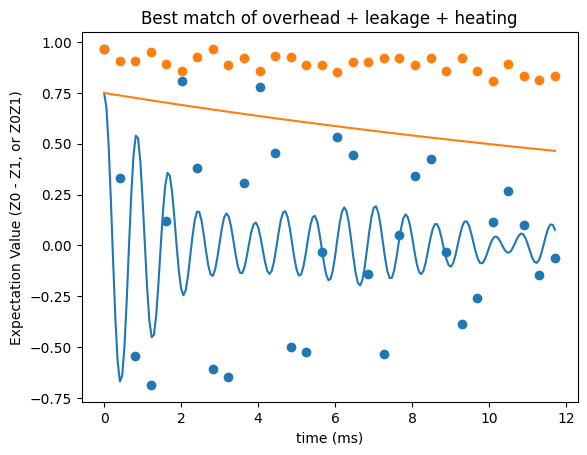

In [24]:
prefactor_avg = 0.75
plt.plot(t_list, results_Jij_oscillation*prefactor_avg/2, label='Simulated Oscillation')
plt.plot(t_list, (-1*results_Jij_leakage*prefactor_avg), label='Simulated Leakage + overhead')
plt.scatter(times, flopping_matrix[:,0])
plt.scatter(times, 1-leakage_matrix[:,0])
plt.xlabel('time (ms)')
plt.ylabel('Expectation Value (Z0 - Z1, or Z0Z1)')
plt.title('Best match of overhead + leakage + heating')
print(np.sqrt(0.005*J))
print(prefactor_avg)
#plt.hlines(full_results[max_index], 0, 10, color='r')
#plt.hlines(full_results[second_max_index], 0, 10, color='r')
#plt.hlines(full_results[third_max_index], 0, 10, color='r')

[0.00368728 0.06151971]
[0.00368728 0.06151971]


Text(0, 0.5, 'Leakage Subspace Percentage')

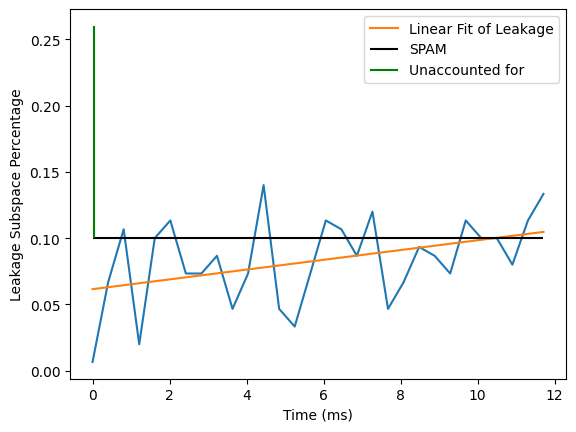

In [25]:

index = 1
#plt.plot(t_list, (results_Jij_leakage + 0.06 + 1))
plt.plot(times, (leakage_matrix[:,index]))
#fit to a line the leakage matrix: 
def linear(x, m, b):
    return m*x + b
def exp(x, a, b):
    return a-np.exp(b*x)
popt, pcov = curve_fit(linear, times, leakage_matrix[:,index])
print(popt)
plt.plot(times, linear(times, *popt), label='Linear Fit of Leakage')
print(popt)
plt.hlines(0.1, 0, max(times), colors='k', label='SPAM')
#Make an arrow between 0.18 and 0.06 at x axis = 0 with the label 'unaccounted for'
plt.vlines(0.05, .1, 0.26, colors='g', label='Unaccounted for')
             #plt.arrow(0.0, 0.018, 0, 0.06, head_width=0.04, head_length=0.005, fc='k', ec='k')
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Leakage Subspace Percentage')
